# 03 - Gradient-Based Policy Optimization

This notebook demonstrates that we can **learn** allocation policies via gradient descent.

Key concepts:
1. **Differentiable simulation**: The entire rollout is differentiable w.r.t. policy parameters
2. **Loss function**: Negative seed production (we want to maximize seeds)
3. **Gradient descent**: Update policy parameters to improve fitness

This is the core innovation of Arborhedron: using autodiff to learn morphogenetic rules.

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import Array, grad, jit, value_and_grad
import matplotlib.pyplot as plt
import numpy as np

from sim import ClimateConfig, SimConfig, stress
from sim.config import Allocation, TreeState
from sim.dynamics import step, compute_seeds

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Enable 64-bit precision for better gradient stability
jax.config.update('jax_enable_x64', True)

## 1. Parameterized Policy

We define a simple policy with learnable parameters. The policy outputs allocation fractions
based on the current day (progress through season) and tree state.

**Architecture**: Time-dependent logits with softmax normalization

```
logits = early_weights * (1 - progress) + late_weights * progress
allocation = softmax(logits)
```

This allows the policy to learn different strategies for early vs late season.

In [2]:
def init_policy_params(key: Array) -> dict:
    """
    Initialize policy parameters.
    
    Parameters:
    - early_logits: [5] - allocation logits for day 0
    - late_logits: [5] - allocation logits for final day
    
    Order: [roots, trunk, shoots, leaves, flowers]
    """
    k1, k2 = jr.split(key)
    return {
        # Start with slight bias toward growth (leaves, roots)
        'early_logits': jr.normal(k1, (5,)) * 0.5 + jnp.array([0.5, 0.0, 0.2, 0.8, -1.0]),
        # End with bias toward reproduction (flowers)
        'late_logits': jr.normal(k2, (5,)) * 0.5 + jnp.array([0.0, 0.3, 0.2, 0.2, 0.5]),
    }


def apply_policy(params: dict, state: TreeState, day: int, num_days: int) -> Allocation:
    """
    Apply parameterized policy to get allocation.
    
    Interpolates between early and late logits based on progress.
    """
    progress = day / num_days
    
    # Linear interpolation of logits
    logits = params['early_logits'] * (1.0 - progress) + params['late_logits'] * progress
    
    # Softmax for valid allocation
    probs = jax.nn.softmax(logits)
    
    return Allocation(
        roots=probs[0],
        trunk=probs[1],
        shoots=probs[2],
        leaves=probs[3],
        flowers=probs[4],
    )


# Test initialization
key = jr.PRNGKey(42)
params = init_policy_params(key)
print("Initial early logits:", params['early_logits'])
print("Initial late logits:", params['late_logits'])

Initial early logits: [ 0.13984964 -0.13031116  1.04078425  0.70413616 -0.26952392]
Initial late logits: [ 0.32494601  0.3592393  -0.5778597  -0.03096183  1.34729665]


## 2. Differentiable Rollout

We implement a simplified rollout that's fully JIT-compatible.
This uses `jax.lax.fori_loop` for efficient compilation.

In [3]:
def rollout_jit(
    params: dict,
    config: SimConfig,
    light_arr: Array,
    moisture_arr: Array,
    wind_arr: Array,
) -> tuple[TreeState, Array]:
    """
    JIT-compatible rollout for gradient computation.
    
    Returns final state and seed count.
    """
    num_days = config.num_days
    
    def body_fn(day: int, state: TreeState) -> TreeState:
        allocation = apply_policy(params, state, day, num_days)
        return step(
            state=state,
            allocation=allocation,
            light=light_arr[day],
            moisture=moisture_arr[day],
            wind=wind_arr[day],
            config=config,
            day=day,
        )
    
    initial_state = TreeState.initial(energy=config.seed_energy)
    final_state = jax.lax.fori_loop(0, num_days, body_fn, initial_state)
    seeds = compute_seeds(final_state, config)
    
    return final_state, seeds


# Precompute environment arrays
config = SimConfig(num_days=100)
climate = ClimateConfig.mild()
light_arr, moisture_arr, wind_arr = stress.compute_environment_batch(climate, config.num_days)

# Test rollout
final_state, seeds = rollout_jit(params, config, light_arr, moisture_arr, wind_arr)
print(f"Initial policy seeds: {float(seeds):.4f}")
print(f"Final biomass: {float(final_state.total_biomass()):.4f}")

Initial policy seeds: 0.5384
Final biomass: 2.6864


## 3. Loss Function and Gradients

Our loss function is negative seed production (we minimize loss = maximize seeds).
We also add a small regularization term to prevent extreme logit values.

In [4]:
def loss_fn(
    params: dict,
    config: SimConfig,
    light_arr: Array,
    moisture_arr: Array,
    wind_arr: Array,
    reg_weight: float = 0.001,
) -> Array:
    """
    Compute loss: negative seeds + regularization.
    """
    _, seeds = rollout_jit(params, config, light_arr, moisture_arr, wind_arr)
    
    # Regularization: penalize extreme logit values
    reg = reg_weight * (
        jnp.sum(params['early_logits'] ** 2) +
        jnp.sum(params['late_logits'] ** 2)
    )
    
    return -seeds + reg


# Create a specialized loss function with config baked in
def make_loss_fn(config: SimConfig, light_arr: Array, moisture_arr: Array, wind_arr: Array):
    """Create a loss function with environment fixed."""
    def loss(params: dict) -> Array:
        return loss_fn(params, config, light_arr, moisture_arr, wind_arr)
    return loss

# Create loss function for this environment
loss_for_env = make_loss_fn(config, light_arr, moisture_arr, wind_arr)

# JIT compile loss and gradient functions
loss_and_grad_fn = jit(value_and_grad(loss_for_env))

# Test gradient computation
loss, grads = loss_and_grad_fn(params)
print(f"Initial loss: {float(loss):.4f}")
print(f"Gradient norms:")
print(f"  early_logits: {float(jnp.linalg.norm(grads['early_logits'])):.6f}")
print(f"  late_logits: {float(jnp.linalg.norm(grads['late_logits'])):.6f}")

Initial loss: -0.5344
Gradient norms:
  early_logits: 0.344662
  late_logits: 0.258438


## 4. Gradient Descent Training

Now we run gradient descent to optimize the policy parameters.

In [5]:
def train_policy(
    params: dict,
    loss_grad_fn,
    rollout_fn,
    num_steps: int = 200,
    learning_rate: float = 0.1,
) -> tuple[dict, list[float], list[float]]:
    """
    Train policy via gradient descent.
    
    Returns optimized params, loss history, and seed history.
    """
    loss_history = []
    seed_history = []
    
    for i in range(num_steps):
        loss, grads = loss_grad_fn(params)
        loss_history.append(float(loss))
        
        # Compute seeds for tracking
        _, seeds = rollout_fn(params)
        seed_history.append(float(seeds))
        
        # Gradient descent update
        params = {
            'early_logits': params['early_logits'] - learning_rate * grads['early_logits'],
            'late_logits': params['late_logits'] - learning_rate * grads['late_logits'],
        }
        
        if i % 50 == 0:
            print(f"Step {i:3d}: loss={float(loss):.4f}, seeds={float(seeds):.4f}")
    
    return params, loss_history, seed_history


# Create rollout function for tracking seeds
def make_rollout_fn(config, light_arr, moisture_arr, wind_arr):
    def rollout(params):
        return rollout_jit(params, config, light_arr, moisture_arr, wind_arr)
    return jit(rollout)

rollout_fn = make_rollout_fn(config, light_arr, moisture_arr, wind_arr)

# Train!
print("Training policy...")
print("=" * 50)
optimized_params, loss_history, seed_history = train_policy(
    params, 
    loss_and_grad_fn,
    rollout_fn,
    num_steps=200,
    learning_rate=0.1,
)
print("=" * 50)
print(f"Final seeds: {seed_history[-1]:.4f}")
print(f"Improvement: {seed_history[-1] / max(seed_history[0], 0.001):.1f}x")

Training policy...
Step   0: loss=-0.5344, seeds=0.5384
Step  50: loss=-0.9929, seeds=0.9984
Step 100: loss=-1.1345, seeds=1.1413
Step 150: loss=-1.1881, seeds=1.1965
Final seeds: 1.2251
Improvement: 2.3x


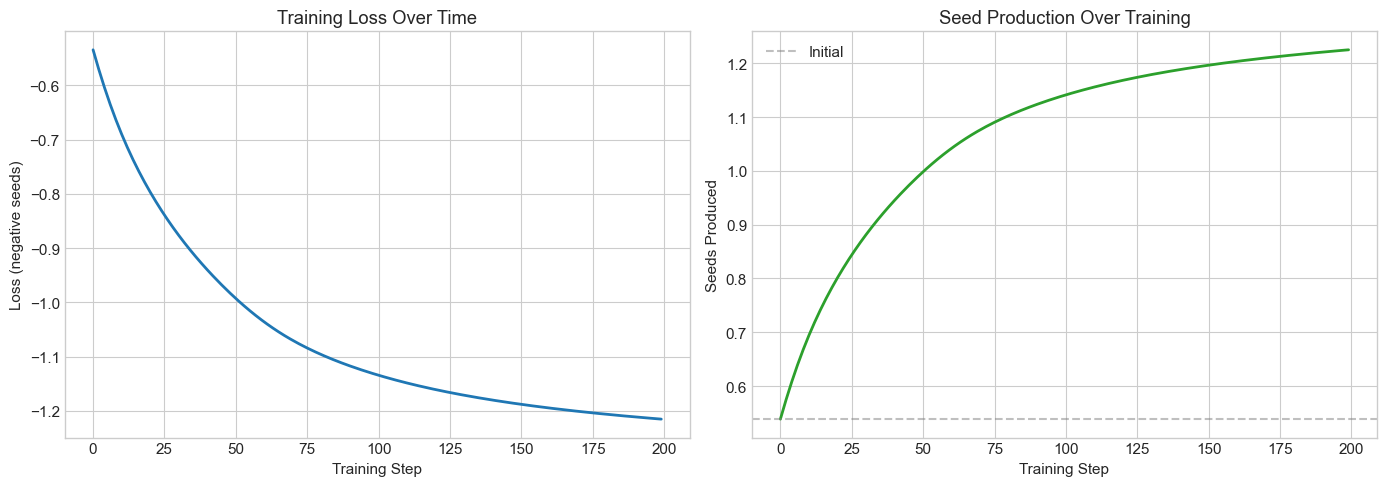

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(loss_history, linewidth=2)
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Loss (negative seeds)')
ax1.set_title('Training Loss Over Time')

ax2.plot(seed_history, linewidth=2, color='tab:green')
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Seeds Produced')
ax2.set_title('Seed Production Over Training')
ax2.axhline(y=seed_history[0], color='gray', linestyle='--', alpha=0.5, label='Initial')
ax2.legend()

plt.tight_layout()
plt.show()

## 5. Learned Policy Analysis

Let's examine what strategy the optimizer discovered.

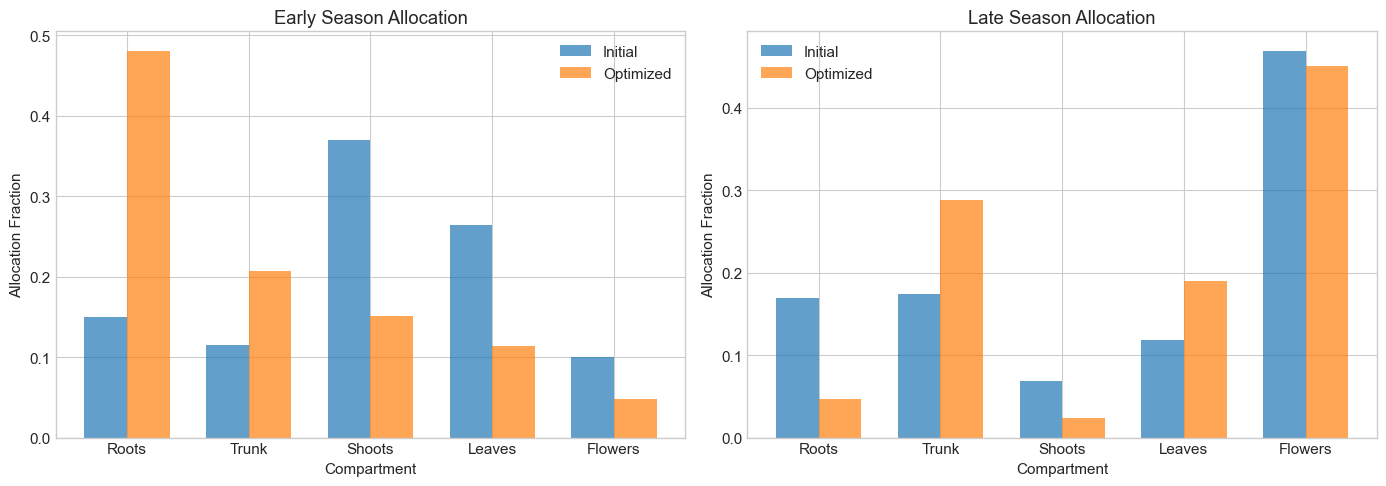

In [7]:
# Compare initial vs optimized logits
# Note: 'params' was overwritten during training, so we reinitialize for comparison
initial_params = init_policy_params(jr.PRNGKey(42))
labels = ['Roots', 'Trunk', 'Shoots', 'Leaves', 'Flowers']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(labels))
width = 0.35

# Early season
ax = axes[0]
early_init = jax.nn.softmax(initial_params['early_logits'])
early_opt = jax.nn.softmax(optimized_params['early_logits'])
ax.bar(x - width/2, early_init, width, label='Initial', alpha=0.7)
ax.bar(x + width/2, early_opt, width, label='Optimized', alpha=0.7)
ax.set_xlabel('Compartment')
ax.set_ylabel('Allocation Fraction')
ax.set_title('Early Season Allocation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Late season
ax = axes[1]
late_init = jax.nn.softmax(initial_params['late_logits'])
late_opt = jax.nn.softmax(optimized_params['late_logits'])
ax.bar(x - width/2, late_init, width, label='Initial', alpha=0.7)
ax.bar(x + width/2, late_opt, width, label='Optimized', alpha=0.7)
ax.set_xlabel('Compartment')
ax.set_ylabel('Allocation Fraction')
ax.set_title('Late Season Allocation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

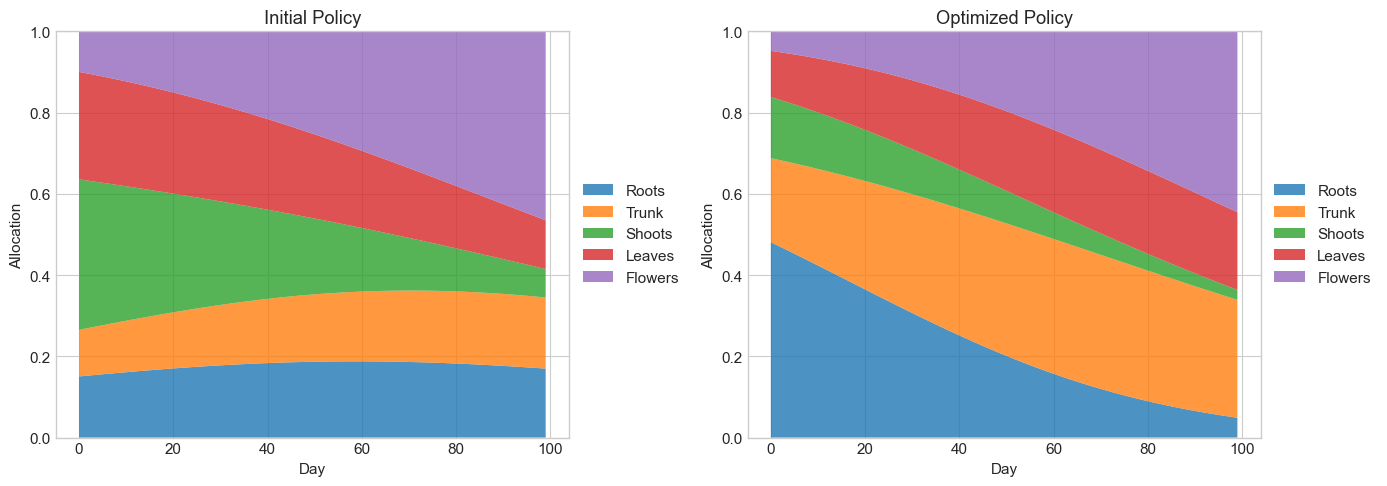

In [8]:
# Visualize allocation over season
days = np.arange(config.num_days)

def get_allocation_trajectory(params, num_days):
    state = TreeState.initial()
    allocs = {'roots': [], 'trunk': [], 'shoots': [], 'leaves': [], 'flowers': []}
    for day in range(num_days):
        a = apply_policy(params, state, day, num_days)
        allocs['roots'].append(float(a.roots))
        allocs['trunk'].append(float(a.trunk))
        allocs['shoots'].append(float(a.shoots))
        allocs['leaves'].append(float(a.leaves))
        allocs['flowers'].append(float(a.flowers))
    return allocs

init_allocs = get_allocation_trajectory(initial_params, config.num_days)
opt_allocs = get_allocation_trajectory(optimized_params, config.num_days)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.stackplot(days,
    init_allocs['roots'], init_allocs['trunk'], init_allocs['shoots'],
    init_allocs['leaves'], init_allocs['flowers'],
    labels=labels, alpha=0.8)
ax.set_xlabel('Day')
ax.set_ylabel('Allocation')
ax.set_title('Initial Policy')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(0, 1)

ax = axes[1]
ax.stackplot(days,
    opt_allocs['roots'], opt_allocs['trunk'], opt_allocs['shoots'],
    opt_allocs['leaves'], opt_allocs['flowers'],
    labels=labels, alpha=0.8)
ax.set_xlabel('Day')
ax.set_ylabel('Allocation')
ax.set_title('Optimized Policy')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 6. Comparison: Optimized vs Baseline

Let's compare the optimized policy against the hand-coded baseline.

In [9]:
from sim import policies, run_season

# Run baseline policy
baseline_traj = run_season(config, climate, policies.baseline_policy)

# Run optimized policy (need to wrap in standard policy interface)
def optimized_policy_fn(state, day, num_days, wind):
    return apply_policy(optimized_params, state, day, num_days)

optimized_traj = run_season(config, climate, optimized_policy_fn)

print("Policy Comparison:")
print("=" * 50)
print(f"{'Metric':<20} {'Baseline':>12} {'Optimized':>12}")
print("-" * 50)
print(f"{'Seeds':<20} {float(baseline_traj.seeds):>12.4f} {float(optimized_traj.seeds):>12.4f}")
print(f"{'Final Biomass':<20} {float(baseline_traj.states[-1].total_biomass()):>12.4f} {float(optimized_traj.states[-1].total_biomass()):>12.4f}")
print(f"{'Final Energy':<20} {float(baseline_traj.states[-1].energy):>12.4f} {float(optimized_traj.states[-1].energy):>12.4f}")
print(f"{'Final Flowers':<20} {float(baseline_traj.states[-1].flowers):>12.4f} {float(optimized_traj.states[-1].flowers):>12.4f}")
print(f"{'Final Trunk':<20} {float(baseline_traj.states[-1].trunk):>12.4f} {float(optimized_traj.states[-1].trunk):>12.4f}")
print("=" * 50)

Policy Comparison:
Metric                   Baseline    Optimized
--------------------------------------------------
Seeds                      0.7849       1.2256
Final Biomass              3.3480       3.6887
Final Energy               0.3494       0.3514
Final Flowers              0.4323       0.6642
Final Trunk                1.2182       1.1021


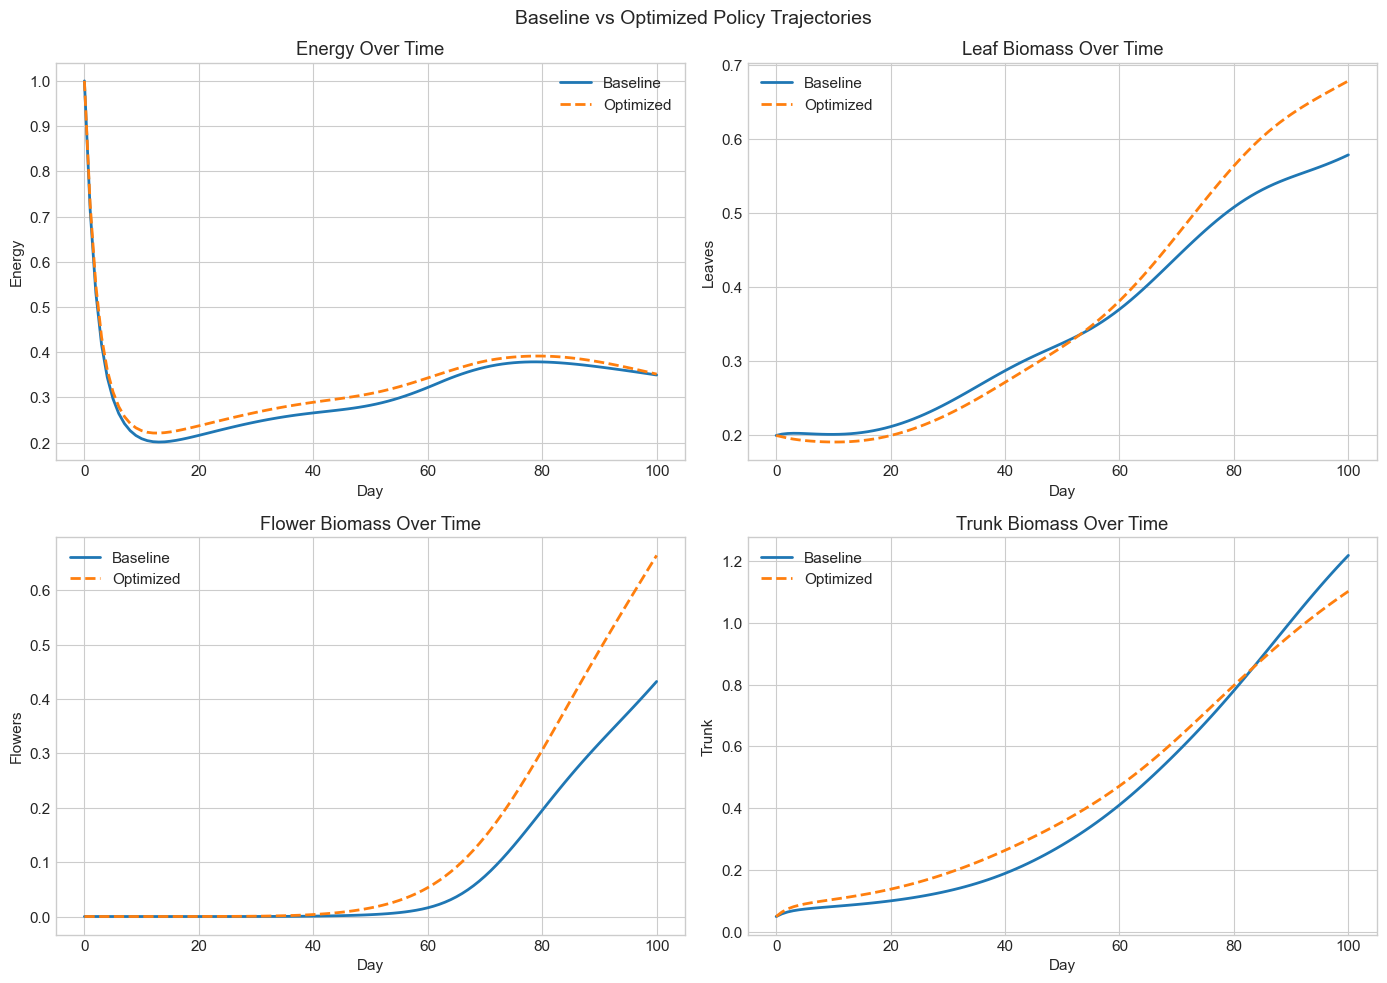

In [10]:
# Visual comparison of trajectories
baseline_states = baseline_traj.get_state_arrays()
optimized_states = optimized_traj.get_state_arrays()
days = np.arange(len(baseline_traj.states))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax = axes[0, 0]
ax.plot(days, baseline_states['energy'], label='Baseline', linewidth=2)
ax.plot(days, optimized_states['energy'], label='Optimized', linewidth=2, linestyle='--')
ax.set_xlabel('Day')
ax.set_ylabel('Energy')
ax.set_title('Energy Over Time')
ax.legend()

ax = axes[0, 1]
ax.plot(days, baseline_states['leaves'], label='Baseline', linewidth=2)
ax.plot(days, optimized_states['leaves'], label='Optimized', linewidth=2, linestyle='--')
ax.set_xlabel('Day')
ax.set_ylabel('Leaves')
ax.set_title('Leaf Biomass Over Time')
ax.legend()

ax = axes[1, 0]
ax.plot(days, baseline_states['flowers'], label='Baseline', linewidth=2)
ax.plot(days, optimized_states['flowers'], label='Optimized', linewidth=2, linestyle='--')
ax.set_xlabel('Day')
ax.set_ylabel('Flowers')
ax.set_title('Flower Biomass Over Time')
ax.legend()

ax = axes[1, 1]
ax.plot(days, baseline_states['trunk'], label='Baseline', linewidth=2)
ax.plot(days, optimized_states['trunk'], label='Optimized', linewidth=2, linestyle='--')
ax.set_xlabel('Day')
ax.set_ylabel('Trunk')
ax.set_title('Trunk Biomass Over Time')
ax.legend()

plt.suptitle('Baseline vs Optimized Policy Trajectories', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Summary

This notebook demonstrated **gradient-based policy optimization** for tree growth:

### Key Results
1. **Differentiability**: Gradients flow through the entire 100-day rollout
2. **Learning works**: The optimizer improved seed production from initial random policy
3. **Interpretable strategies**: The learned policy shows clear early/late season patterns

### What the Optimizer Learned
- Early season: Focus on leaves/roots for photosynthetic capacity
- Late season: Shift to flowers for reproduction
- Trunk investment: Balanced throughout for structural support

### Next Steps
1. **Neural policies**: Replace linear interpolation with neural networks
2. **Multi-climate training**: Optimize for robustness across environments
3. **Curriculum learning**: Start in easy climates, gradually increase difficulty
4. **Population-based training**: Evolve diverse policy families